In [1]:
import sys,os
sys.path.append(r'C:\Users\MERFISH8\Scripts\CommonTools')
import MosaicToolsPy3 as mt
import numpy as np, matplotlib.pyplot as plt
import numpy
import pickle
import imp
imp.reload(mt)
#from PIL import Image
#pip install pillow=4.0.0
#pip install opencv-python
#conda activate py27
#python -m pip install Pillow

<module 'MosaicToolsPy3' from 'C:\\Users\\MERFISH8\\Scripts\\CommonTools\\MosaicToolsPy3.py'>

Started loading images
Finished loading images


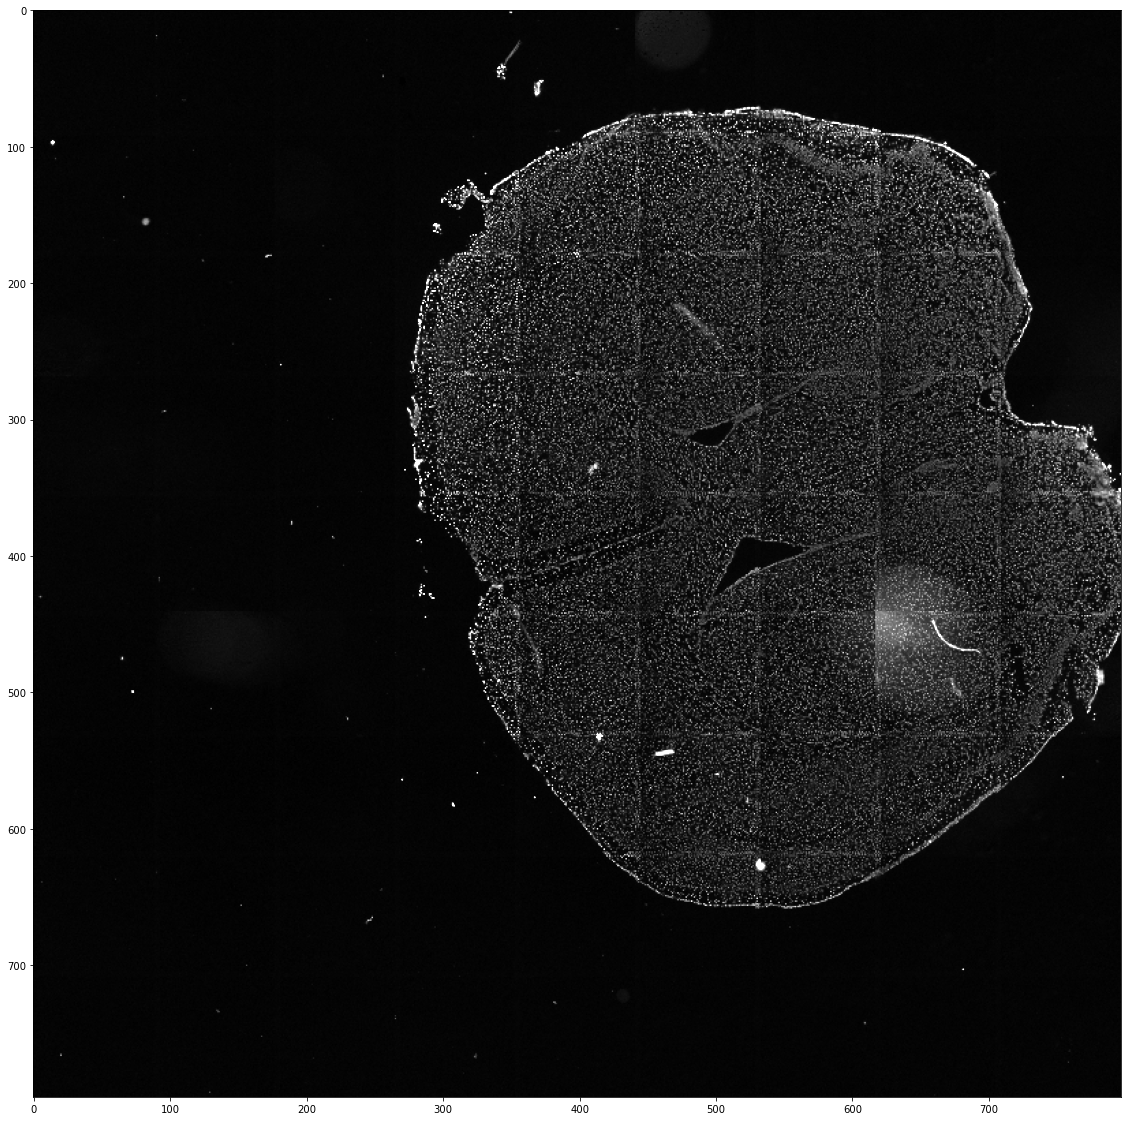

In [2]:
mosaic = mt.Mosaic()
folder = r'D:\Data\BB_WEA_SindV1_slide9_regAMP3x_12_12_2020_split\mosaic'
mosaic.load(folder,nmax=None)

#reload(mt)
mosaic.get_ims()
mosaic.get_mosaic(rot=0,um_per_pixel_dic={'10x':0.648,'60x':0.648,'100x':0.107,'20x':0.46},
                  invert_X=False,invert_Y=False,transpose=True)

plt.figure(figsize=(20,20))
plt.imshow(mosaic.im[::20,::20],vmax=12,vmin=0.75,cmap='gray')
plt.show()

In [3]:
mosaic.save(folder+'.png',im_min=0.75,im_max=12)

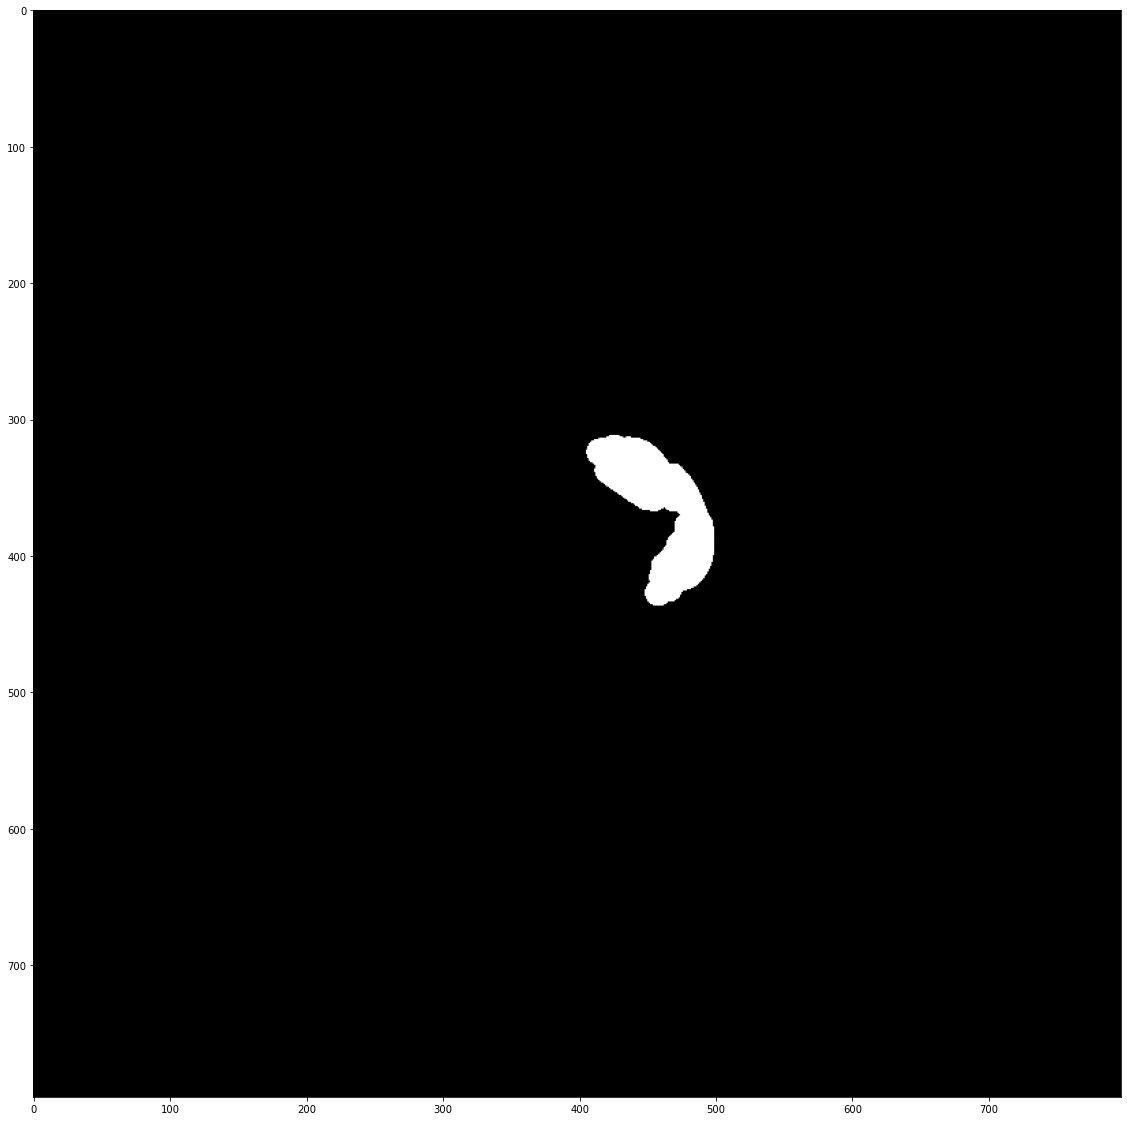

In [4]:
import cv2
im = cv2.imread(folder+r"_mask.tif")

plt.figure(figsize=(20,20))
plt.imshow(im[::20,::20],cmap='gray')
plt.show()

C:\Users\MERFISH8\Scripts\CommonTools\MosaicToolsPy3.py:61: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return im[slices]


Number of snaps:36


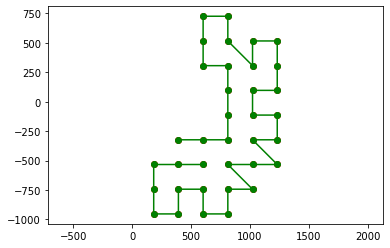

In [5]:
import matplotlib.pyplot as plt
import sys
import cv2
import numpy

low_mag_pixel_size = 0.65 #pixel size of lowmag
high_mag_pixel_size = 0.108
fov_sz = 2048.

xoffset,yoffset = 182.00,58.00 #offset between low mag and high mag objectives


x_start,y_start = 0,0 #starting positions




#image  = cv2.imread(os.path.dirname(folder)+os.sep+r"mosaic_mask.png")[:,:,0]
image = cv2.imread(folder+r"_mask.tif")[:,:,0]
xsz,ysz=image.shape

obj_ratio=low_mag_pixel_size/high_mag_pixel_size
sz=np.array([fov_sz/obj_ratio,fov_sz/obj_ratio])*0.95
sz_=[fov_sz/obj_ratio,fov_sz/obj_ratio]
im_=numpy.array(image)
xcand = np.arange(0,int(im_.shape[0]),int(sz[0]))+sz[0]/2
ycand = np.arange(0,int(im_.shape[1]),int(sz[1]))+sz[1]/2
x,y = zip(*mt.flatten([[(x__,y__) for x__ in xcand if np.sum(mt.grab_block(im_,[x__,y__],sz_))] for y__ in ycand]))
x,y= (numpy.array(x))/sz[0],(numpy.array(y))/sz[1]


Point = complex
cities = frozenset(Point(x[i],y[i]) for i in range(len(x)))
cities_sort=mt.alter_tour(mt.greedy_tsp(cities))
x2=[val.real for val in cities_sort]
y2=[val.imag for val in cities_sort]
#plt.figure(figsize=(20,20))
#plt.imshow(numpy.array(im_small)>0)
x_ = (numpy.array(x2))*sz[0]
y_ = (numpy.array(y2))*sz[1]

filename=os.path.dirname(folder)+os.sep+r'pos2.txt'
pix_sz=high_mag_pixel_size*obj_ratio
dics=mosaic.dics
pos_x = numpy.array([dic['x_um'] for dic in dics],dtype=int)
pos_y = numpy.array([dic['y_um'] for dic in dics],dtype=int)
starts=min(pos_x),min(pos_y)
offset = fov_sz/2*low_mag_pixel_size

x = starts[0]+(numpy.array(x2))*sz[0]*pix_sz+xoffset-offset#This is -X offset
y = starts[1]+(numpy.array(y2))*sz[1]*pix_sz+yoffset-offset#This is -Y offset

#####################################################################           XMIN             #########################



#x_min,x_max=-np.inf,np.inf
def select_points(x,y,delta_x_keep):
    x_min = np.mean(x)-delta_x_keep/2.
    x_max = np.mean(x)+delta_x_keep/2.
    x_keep,y_keep = [],[]
    for x_t,y_t in zip(x,y):
        if x_t>x_min and x_t<x_max:
            x_keep.append(x_t)
            y_keep.append(y_t)
    x_keep = np.array(x_keep)
    y_keep = np.array(y_keep)
    return x_keep,y_keep
x_keep,y_keep = select_points(x,y,np.inf)
plt.plot(y_keep,x_keep,'ro')
#x_keep,y_keep = select_points(x,y,11000.)





ind0 = np.argmin((x_keep-x_start)**2+(y_keep-y_start)**2)

x_keep = np.roll(x_keep,-ind0)
y_keep = np.roll(y_keep,-ind0)
fid=open(filename,'w')
for x_t,y_t in zip(x_keep,y_keep):
    fid.write(str(x_t)+','+str(y_t)+'\n')
fid.close()
print("Number of snaps:" + str(len(x_keep)))

#plt.imshow(im_)
plt.plot(y_keep,x_keep,'g-o')

plt.axis('equal')
plt.show()

In [6]:
import sys,os,glob
sys.path.append(r'C:\Users\MERFISH8\Scripts\CommonTools')
import numpy as np, matplotlib.pyplot as plt
import pickle
import imp
import MaxViewer_py3 as mv
import tifffile
from tqdm import tqdm_notebook as tqdm
import AlignmentTools_py3 as at

In [7]:
#Useful functions
import cv2
def quick_norm(im,s=50):
    return np.array([im_/cv2.blur(im_,(s,s))for im_ in im.astype(np.float32)])
from sklearn.cluster import DBSCAN
def get_local_max(im_dif,th_fit,delta=2,delta_fit=3,dbscan=True):
    """Given a 3D image <im_dif> as numpy array, get the local maxima in cube -<delta>_to_<delta> in 3D.
    Optional a dbscan can be used to couple connected pixels with the same local maximum. 
    This is important if saturating the camera values.
    
    Returns: Xh - a list of z,x,y and brightness of the local maxima
    """
    z,x,y = np.nonzero(im_dif>th_fit)
    zmax,xmax,ymax = im_dif.shape
    in_im = im_dif[z,x,y]
    keep = np.ones(len(x))>0
    for d1 in range(-delta,delta+1):
        for d2 in range(-delta,delta+1):
            for d3 in range(-delta,delta+1):
                keep &= (in_im>=im_dif[(z+d1)%zmax,(x+d2)%xmax,(y+d3)%ymax])
    z,x,y = z[keep],x[keep],y[keep]
    h = in_im[keep]
    Xh = np.array([z,x,y,h]).T
    if dbscan:
        from sklearn.cluster import DBSCAN
        db = DBSCAN(eps=1, min_samples=1, metric='euclidean')
        X = np.array([z,x,y]).T
        db.fit(X)
        l = db.labels_
        Xh = []
        for l_ in np.unique(l):
            keep = l==l_
            imax = np.argmax(h[keep])
            Xh.append([z[keep][imax],x[keep][imax],y[keep][imax],h[keep][imax]])
        Xh = np.array(Xh)
    
    if delta_fit!=0:
        z,x,y,h = Xh.T
        z,x,y = z.astype(int),x.astype(int),y.astype(int)
        im_centers = [[],[],[],[]]
        for d1 in range(-delta_fit,delta_fit+1):
            for d2 in range(-delta_fit,delta_fit+1):
                for d3 in range(-delta_fit,delta_fit+1):
                    if (d1*d1+d2*d2+d3*d3)<=(delta_fit*delta_fit):
                        im_centers[0].append((z+d1))
                        im_centers[1].append((x+d2))
                        im_centers[2].append((y+d3))
                        im_centers[3].append(im[(z+d1)%zmax,(x+d2)%xmax,(y+d3)%ymax])

        im_centers_ = np.array(im_centers)
        im_centers_[-1] -= np.min(im_centers_[-1],axis=0)
        zc = np.sum(im_centers_[0]*im_centers_[-1],axis=0)/np.sum(im_centers_[-1],axis=0)
        xc = np.sum(im_centers_[1]*im_centers_[-1],axis=0)/np.sum(im_centers_[-1],axis=0)
        yc = np.sum(im_centers_[2]*im_centers_[-1],axis=0)/np.sum(im_centers_[-1],axis=0)
        Xh = np.array([zc,xc,yc,h]).T
    return Xh
import AlignmentTools_py3 as at
def series_align(im1,im2,s = 256,gb=30):
    """
    Given 2 3D images <im1> and <im2> this performs a fft based registration. 
    Robustness measures:
    1) Uses local gaussian correction (dividing the images by gaussian blur) with a kernel size <gb> of 30 piexels. 
    (This is to avoid the fft getting confused by global illumination and focusing on the feature at scale <gb>)
    
    2) Will tile the images <im1> and <im2> in s x s little images and compare each one. Will then use the consensus registration
    
    Returns:
    tzxy - the delta z,x and y between the images
    vecs - a list of tzxy for each subimage comparison (see point 2 above) to troubleshoot
    """
    
    sz,sx,sy = im1.shape
    vecs = []
    for ix in range(0,sx-1,s):
        for iy in range(0,sy-1,s):
            vecs.append(at.fft3d_from2d(im1[:,ix:ix+s,iy:iy+s],im2[:,ix:ix+s,iy:iy+s],gb=gb))
    tzxy = np.median(vecs,axis=0)
    #consistency = np.mean(np.abs(vecs-tzxy),axis=0)
    return tzxy,vecs


In [8]:
H_folders = [fld for fld in glob.glob('D:\Data\BB_WEA_SindV1_slide9_regAMP3x_12_12_2020_split\H*') if 'H0' not in fld]
fovs = glob.glob(H_folders[0]+os.sep+'*.tif')
fovs = [os.path.basename(fv)for fv in np.sort(fovs)]


fov = fovs[14]
ims = []
ims_nms = []
cols = ['750','647','561','405']
ncols = len(cols)
for fld in tqdm(H_folders):
    fl = fld+os.sep+fov
    if os.path.exists(fl):
        im = tifffile.imread(fl)
        for icol,col in enumerate(cols):
            ims.append(im[icol::ncols])
            ims_nms.append(os.path.basename(fld)+'_'+col)

<ipython-input-8-6694223267fe>:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for fld in tqdm(H_folders):


In [9]:
%matplotlib notebook

<IPython.core.display.Javascript object>


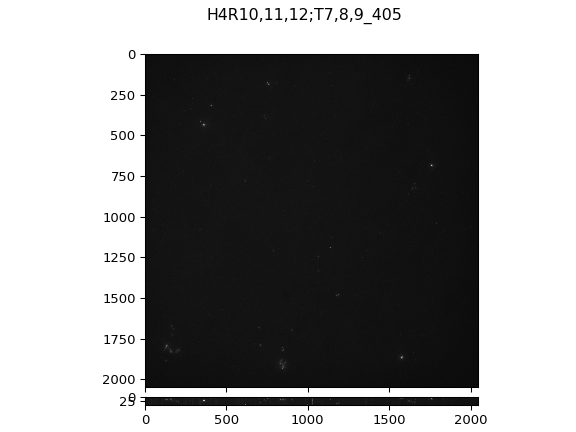

In [10]:
obj = mv.imshow_mark_3d(ims,image_names=ims_nms)

In [44]:
obj.dic_min_max

{0: [467, 4407],
 1: [865, 32993],
 2: [852, 65535],
 4: [680, 5351],
 5: [2184, 10343],
 9: [1487, 4835]}

In [51]:
obj.index_im

21

In [60]:
import sys,os
sys.path.append(r'C:\Users\MERFISH8\Scripts\CommonTools')
import MosaicToolsPy3 as mt
import numpy as np, matplotlib.pyplot as plt
import numpy,glob
import pickle
import imp
from imp import reload
import IOTools_py3 as io
from tqdm import tqdm_notebook as tqdm
#from PIL import Image
#pip install pillow=4.0.0
#pip install opencv-python
#conda activate py27
#python -m pip install Pillow
import cv2
from sklearn.cluster import KMeans

def rotate(image, angle, center=None, scale=1.0):
    # grab the dimensions of the image
    (h, w) = image.shape[:2]
    # if the center is None, initialize it as the center of
    # the image
    if center is None:
        center = (w // 2, h // 2)
    # perform the rotation
    M = cv2.getRotationMatrix2D(center, angle, scale)
    rotated = cv2.warpAffine(image, M, (w, h))
    # return the rotated image
    return rotated
def norm_sets(ims,norm_dapi=True,perc =80,nl = 30):
    normns = [1 for im_ in ims ]
    if norm_dapi and len(ims)>nl:
        normns = [np.percentile(im_,perc) for im_ in ims]        
        nll = int(nl/2)
        norms_ = list(normns[:nll][::-1])+list(normns)+list(normns[-nll:][::-1])
        norms_ = [np.median(norms_[il:il+nl]) for il in range(len(norms_)-nl)]
        normns = [e/norms_[0] for e in norms_]
    return normns
def save_tile_image_and_label(fls_iter,save_file,resc=2,custom_frms=None,pix_size_=0.162,
                        max_impose=True,verbose=False,im_cor__=None,
                              rotation_angle=0,add_txt=True,norm_dapi=False,invertX=False,invertY=False,transpose=False):

        import tifffile
        ims,xys=[],[]
        pix_size=pix_size_*resc
        fls_iter_ = fls_iter
        if verbose: fls_iter_ = tqdm(fls_iter)
        for dax in fls_iter_:
            

            dic_inf = io.readInfoFile(dax)
            
            #Read appropriate frames
                        
            #dapi_im = [io.DaxReader(dax).loadAFrane(frm) for frm in custom_frms]
            dapi_im = [tifffile.imread(dax,key=frm) for frm in custom_frms]
            
            dapi_im_small  = np.array(dapi_im)[:,1:-1:resc,1:-1:resc]
            
            #Illumination correction:
            dapi_im_small = np.max(dapi_im_small,0)
            #Consider adding illumination correction and better stitching
            xys.append([dic_inf['Stage X']/pix_size,dic_inf['Stage Y']/pix_size])
            ims.append(dapi_im_small)

        if im_cor__ is None:
            im_cor = np.median(ims,axis=0)
            ims = [im_/im_cor*np.median(im_cor) for im_ in ims]
        else:
            im_cor = im_cor__[1:-1:resc,1:-1:resc].copy()
            ims = [im_/im_cor*np.median(im_cor) for im_ in ims]
        xys_=np.array(xys,dtype=int)
        xys_=xys_-np.expand_dims(np.min(xys_,axis=0), axis=0)

        if len(ims[0].shape)>2:
            sx,sy,sz = ims[0].shape
            dim_base = list(np.max(xys_,axis=0)+np.array([sx+1,sy+1]))
            dim_base+=[sz]
        else:
            sx,sy = ims[0].shape
            dim_base = list(np.max(xys_,axis=0)+np.array([sx+1,sy+1]))
        if not os.path.exists(os.path.dirname(save_file)):
            os.makedirs(os.path.dirname(save_file))
        im_base = np.zeros(dim_base,dtype=float)
        im_compare = np.zeros(dim_base,dtype=float)
        infos_filename = '.'.join(save_file.split('.')[:-1])+'.infos'
        fid = open(infos_filename,'w')
        

        normns = norm_sets(ims,norm_dapi=norm_dapi,perc =80,nl = 30)
        
        
        for i_,(im,(x,y),norm) in enumerate(zip(ims[:],xys_[:],normns)):
            Ix = int((1-2*invertX))
            Iy = int((1-2*invertY))
            ax_ = 1 if transpose else 0
            im_ = np.swapaxes(im[::Ix,::Iy,...],0,ax_)
            im_cor_ = np.swapaxes(im_cor[::Ix,::Iy,...],0,ax_)#[::-1,::-1]
            im_cor_ = im_cor_.astype(np.float32)
            im_cor_ -= np.percentile(im_cor_,1)
            
            im_cor_[im_cor_<0]=0
            
            #im_ = im_[::-1,::-1]
            im_ = im_/norm
            if rotation_angle!=0:
                im_ = rotate(im_, rotation_angle, center=None, scale=1.0)
                im_cor_ = rotate(im_cor_, rotation_angle, center=None, scale=1.0)
            if max_impose:
                #im_base[x:sx+x,y:sy+y,...]=np.max([im_base[x:sx+x,y:sy+y,...],im_],axis=0)
                #im_ind = im_compare[x:sx+x,y:sy+y,...]>im_cor_
                #im_compare[x:sx+x,y:sy+y,...] = np.max([im_compare[x:sx+x,y:sy+y,...],im_cor_],axis=0)
                im_base[x:sx+x,y:sy+y,...]=(im_compare[x:sx+x,y:sy+y,...]*im_base[x:sx+x,y:sy+y,...]+im_cor_*im_)/(im_compare[x:sx+x,y:sy+y,...]+im_cor_)
                im_compare[x:sx+x,y:sy+y,...]=(im_compare[x:sx+x,y:sy+y,...]*im_compare[x:sx+x,y:sy+y,...]+im_cor_*im_cor_)/(im_compare[x:sx+x,y:sy+y,...]+im_cor_)
                
                im_compare[x:sx+x,y:sy+y,...][np.isnan(im_compare[x:sx+x,y:sy+y,...])]=0
                im_base[x:sx+x,y:sy+y,...][np.isnan(im_base[x:sx+x,y:sy+y,...])]=np.nanmedian(im_base[x:sx+x,y:sy+y,...])
                #im_sel[im_ind]#np.mean([im_base[x:sx+x,y:sy+y,...],im_],axis=0)
            else:
                im_base[x:sx+x,y:sy+y,...]=im_
            if add_txt:
            
                txt = os.path.basename(fls_iter[i_]).split('_')[-1].split('.')[0]
                im_base = cv2.putText(im_base, txt, (y+100,x+100), cv2.FONT_HERSHEY_SIMPLEX ,  1, 2**16-1, 2, cv2.LINE_AA) 
            save_pars = [fls_iter[i_],x,sx+x,y,sy+y,resc]
            fid.write("\t".join(map(str,save_pars))+'\n')
        fid.close()
        tifffile.imsave(save_file,np.clip(im_base,0,2**16-1).astype(np.uint16))
def get_pos(fls_iter):
    X = []
    for fl in fls_iter:
        dic_info = io.readInfoFile(fl)
        X.append([dic_info['Stage X'],dic_info['Stage Y']])
    X = np.array(X)
    return X

In [169]:

folders

['D:\\Data\\BB_WEA_Sind_12_12_2020_split\\H1R1,2,3;TGFP_low',
 'D:\\Data\\BB_WEA_Sind_12_12_2020_split\\H2R4,5,6;T1,2,3_low',
 'D:\\Data\\BB_WEA_Sind_12_12_2020_split\\H3R7,8,9;T4,5,6_low',
 'D:\\Data\\BB_WEA_Sind_12_12_2020_split\\H4R10,11,12;T7,8,9_low',
 'D:\\Data\\BB_WEA_Sind_12_12_2020_split\\H5R13,14,B;T10,11,12_low']

In [97]:
analysis_folder = r'D:\Data\BB_WEA_Sind_12_12_2020_split\Analysis'
if not os.path.exists(analysis_folder):os.makedirs(analysis_folder)
#im_meds = [np.load(analysis_folder+r'\im_med_'+str(fr)+'.npy') for fr in [0,1,2,3]]

fls_iter = glob.glob(r'D:\Data\BB_WEA_Sind_12_12_2020_split\H1R1,2,3;TGFP_low\*.tif')[:-1]
X = get_pos(fls_iter)
iCls = 2
kmeans = KMeans(n_clusters=iCls, random_state=0).fit(X)
L = kmeans.labels_
ncols=4
nframes=200


for iL in [0]:#range(iCls):
    fls_iter_ = np.array(fls_iter)[L==iL]
    tag = os.path.basename(os.path.dirname(fls_iter[0]))
    base_nm = analysis_folder+os.sep+tag
    
    for fr in [20]:#range(76):
        for fr_ in [2]:#range(4):
            save_file = base_nm+r'-S'+str(iL+1)+'__fr-'+str(fr)+'--'+str(fr_)+'.tiff'
            save_tile_image_and_label(fls_iter_[:],save_file,resc=1,custom_frms=[fr*4+fr_],pix_size_=0.108,
                                    max_impose=True,verbose=True,im_cor__=None,#im_meds[fr_],
                                         rotation_angle=-1.5,add_txt=False,norm_dapi=False,
                                      invertY=True,invertX=False,transpose=False)
            print(save_file)

<ipython-input-60-ea57054a645f>:48: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if verbose: fls_iter_ = tqdm(fls_iter)


<ipython-input-60-ea57054a645f>:114: RuntimeWarning: invalid value encountered in true_divide
  im_base[x:sx+x,y:sy+y,...]=(im_compare[x:sx+x,y:sy+y,...]*im_base[x:sx+x,y:sy+y,...]+im_cor_*im_)/(im_compare[x:sx+x,y:sy+y,...]+im_cor_)
<ipython-input-60-ea57054a645f>:115: RuntimeWarning: invalid value encountered in true_divide
  im_compare[x:sx+x,y:sy+y,...]=(im_compare[x:sx+x,y:sy+y,...]*im_compare[x:sx+x,y:sy+y,...]+im_cor_*im_cor_)/(im_compare[x:sx+x,y:sy+y,...]+im_cor_)


D:\Data\BB_WEA_Sind_12_12_2020_split\Analysis\H1R1,2,3;TGFP_low-S1__fr-20--2.tiff


In [ ]:
### Max-projections

In [175]:
analysis_folder = r'D:\Data\BB_WEA_Sind_12_12_2020_split\Analysis'
if not os.path.exists(analysis_folder):os.makedirs(analysis_folder)
#im_meds = [np.load(analysis_folder+r'\im_med_'+str(fr)+'.npy') for fr in [0,1,2,3]]




X = get_pos(fls_iter)
iCls = 2
kmeans = KMeans(n_clusters=iCls, random_state=0).fit(X)
L = kmeans.labels_
ncols=4
nframes=200

folders = glob.glob(r'D:\Data\BB_WEA_Sind_12_12_2020_split\H*_low')
for h_folder in folders:
    fls_iter = glob.glob(h_folder+r'\*.tif')[:-1]
    for iL in range(iCls):
        fls_iter_ = np.array(fls_iter)[L==iL]
        tag = os.path.basename(os.path.dirname(fls_iter[0]))
        base_nm = analysis_folder+os.sep+tag
        for fr_ in range(ncols):
            save_file = base_nm+r'-S'+str(iL+1)+'__fr-all--'+str(fr_)+'.tiff'
            if not os.path.exists(save_file):
                save_tile_image_and_label(fls_iter_[:],save_file,resc=1,custom_frms=np.arange(fr_,nframes,ncols),
                                          pix_size_=0.108,
                                        max_impose=True,verbose=True,im_cor__=None,#im_meds[fr_],
                                             rotation_angle=-1.5,add_txt=False,norm_dapi=False,
                                          invertY=True,invertX=False,transpose=False)
            print(save_file)

D:\Data\BB_WEA_Sind_12_12_2020_split\Analysis\H1R1,2,3;TGFP_low-S1__fr-all--0.tiff
D:\Data\BB_WEA_Sind_12_12_2020_split\Analysis\H1R1,2,3;TGFP_low-S1__fr-all--1.tiff
D:\Data\BB_WEA_Sind_12_12_2020_split\Analysis\H1R1,2,3;TGFP_low-S1__fr-all--2.tiff
D:\Data\BB_WEA_Sind_12_12_2020_split\Analysis\H1R1,2,3;TGFP_low-S1__fr-all--3.tiff
D:\Data\BB_WEA_Sind_12_12_2020_split\Analysis\H1R1,2,3;TGFP_low-S2__fr-all--0.tiff
D:\Data\BB_WEA_Sind_12_12_2020_split\Analysis\H1R1,2,3;TGFP_low-S2__fr-all--1.tiff
D:\Data\BB_WEA_Sind_12_12_2020_split\Analysis\H1R1,2,3;TGFP_low-S2__fr-all--2.tiff
D:\Data\BB_WEA_Sind_12_12_2020_split\Analysis\H1R1,2,3;TGFP_low-S2__fr-all--3.tiff
D:\Data\BB_WEA_Sind_12_12_2020_split\Analysis\H2R4,5,6;T1,2,3_low-S1__fr-all--0.tiff
D:\Data\BB_WEA_Sind_12_12_2020_split\Analysis\H2R4,5,6;T1,2,3_low-S1__fr-all--1.tiff
D:\Data\BB_WEA_Sind_12_12_2020_split\Analysis\H2R4,5,6;T1,2,3_low-S1__fr-all--2.tiff
D:\Data\BB_WEA_Sind_12_12_2020_split\Analysis\H2R4,5,6;T1,2,3_low-S1__fr-all--3.t

<ipython-input-60-ea57054a645f>:48: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if verbose: fls_iter_ = tqdm(fls_iter)


<ipython-input-60-ea57054a645f>:114: RuntimeWarning: invalid value encountered in true_divide
  im_base[x:sx+x,y:sy+y,...]=(im_compare[x:sx+x,y:sy+y,...]*im_base[x:sx+x,y:sy+y,...]+im_cor_*im_)/(im_compare[x:sx+x,y:sy+y,...]+im_cor_)
<ipython-input-60-ea57054a645f>:115: RuntimeWarning: invalid value encountered in true_divide
  im_compare[x:sx+x,y:sy+y,...]=(im_compare[x:sx+x,y:sy+y,...]*im_compare[x:sx+x,y:sy+y,...]+im_cor_*im_cor_)/(im_compare[x:sx+x,y:sy+y,...]+im_cor_)


D:\Data\BB_WEA_Sind_12_12_2020_split\Analysis\H6GFP_low-S1__fr-all--0.tiff



D:\Data\BB_WEA_Sind_12_12_2020_split\Analysis\H6GFP_low-S1__fr-all--1.tiff



D:\Data\BB_WEA_Sind_12_12_2020_split\Analysis\H6GFP_low-S1__fr-all--2.tiff



D:\Data\BB_WEA_Sind_12_12_2020_split\Analysis\H6GFP_low-S1__fr-all--3.tiff



D:\Data\BB_WEA_Sind_12_12_2020_split\Analysis\H6GFP_low-S2__fr-all--0.tiff



D:\Data\BB_WEA_Sind_12_12_2020_split\Analysis\H6GFP_low-S2__fr-all--1.tiff



D:\Data\BB_WEA_Sind_12_12_2020_split\Analysis\H6GFP_low-S2__fr-all--2.tiff



D:\Data\BB_WEA_Sind_12_12_2020_split\Analysis\H6GFP_low-S2__fr-all--3.tiff


In [ ]:
glob.glob(r'D:\Data\BB_WEA_Sind_12_12_2020_split\Analysis\*-S1__fr-all--*.tiff')

In [112]:
#im = tifffile.imread(r'D:\Data\BB_WEA_Sind_12_12_2020_split\Analysis\H1R1,2,3;TGFP_low-S1__fr-20--0.tiff')
im0 = tifffile.imread(r'D:\Data\BB_WEA_Sind_12_12_2020_split\Analysis\H1R1,2,3;TGFP_low-S1__fr-all--0.tiff')
im1 = tifffile.imread(r'D:\Data\BB_WEA_Sind_12_12_2020_split\Analysis\H1R1,2,3;TGFP_low-S1__fr-all--1.tiff')
im2 = tifffile.imread(r'D:\Data\BB_WEA_Sind_12_12_2020_split\Analysis\H1R1,2,3;TGFP_low-S1__fr-all--2.tiff')

im0 = tifffile.imread(r'D:\Data\BB_WEA_Sind_12_12_2020_split\Analysis\H1R1,2,3;TGFP_low-S1__fr-all--0.tiff')
im1 = tifffile.imread(r'D:\Data\BB_WEA_Sind_12_12_2020_split\Analysis\H1R1,2,3;TGFP_low-S1__fr-all--1.tiff')
im2 = tifffile.imread(r'D:\Data\BB_WEA_Sind_12_12_2020_split\Analysis\H1R1,2,3;TGFP_low-S1__fr-all--2.tiff')

<IPython.core.display.Javascript object>


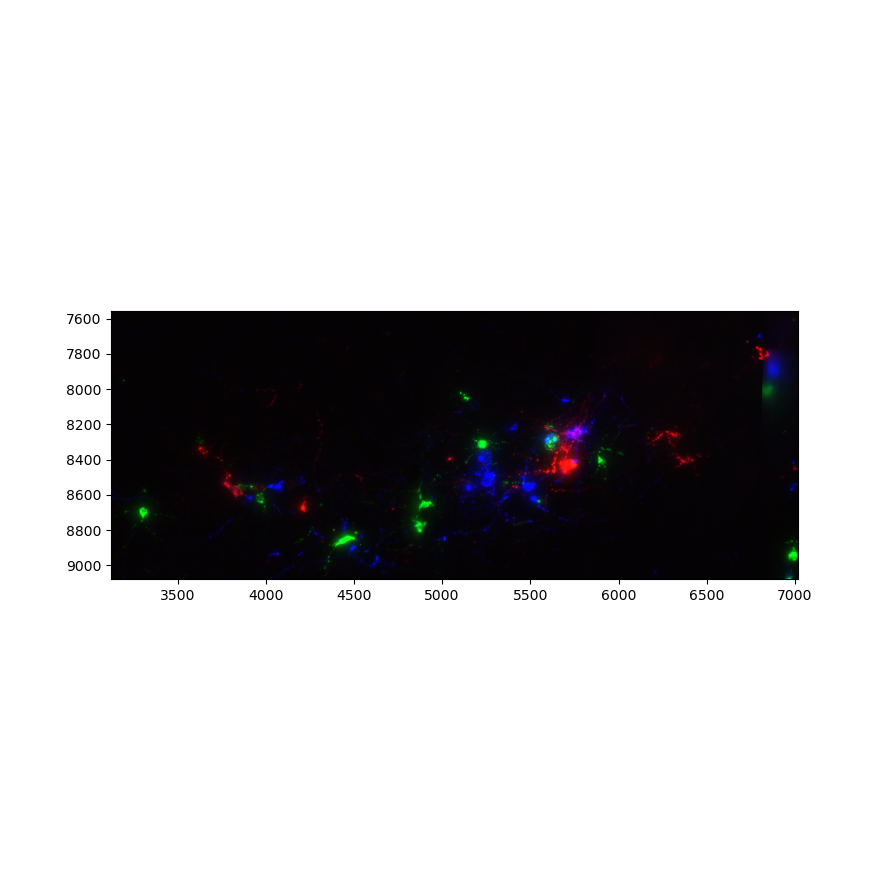

In [120]:
imf = np.dstack([np.clip(im0[::2,::2].astype(np.float32)/10000.,0,1),
 np.clip(im1[::2,::2].astype(np.float32)/20000.,0,1),
 np.clip(im2[::2,::2].astype(np.float32)/60000.,0,1)])
f = plt.figure()
plt.imshow(imf)

In [132]:
ax = f.get_axes()[0]
xm,xM=np.sort(ax.get_xlim()).astype(int)
ym,yM=np.sort(ax.get_ylim()).astype(int)
print(xm,xM,ym,yM)

3121 7019 7555 9077


In [156]:
fls = [r'D:\Data\BB_WEA_Sind_12_12_2020_split\Analysis\H1R1,2,3;TGFP_low-S1__fr-all--0.tiff',
       r'D:\Data\BB_WEA_Sind_12_12_2020_split\Analysis\H1R1,2,3;TGFP_low-S1__fr-all--1.tiff',
       r'D:\Data\BB_WEA_Sind_12_12_2020_split\Analysis\H1R1,2,3;TGFP_low-S1__fr-all--2.tiff',
       r'D:\Data\BB_WEA_Sind_12_12_2020_split\Analysis\H2R4,5,6;T1,2,3_low-S1__fr-all--0.tiff',
       r'D:\Data\BB_WEA_Sind_12_12_2020_split\Analysis\H2R4,5,6;T1,2,3_low-S1__fr-all--1.tiff',
       r'D:\Data\BB_WEA_Sind_12_12_2020_split\Analysis\H2R4,5,6;T1,2,3_low-S1__fr-all--2.tiff']

In [161]:
xm,xM,ym,yM = 3121,7019,7555,9077
#xm,xM,ym,yM = 0,-1,0,-1
hns = [5000,10000,30000,5000,10000,20000]
imf = np.array([np.clip(tifffile.imread(fl)[::2,::2][xm:xM,ym:yM].astype(np.float32)/hns[iim%len(hns)],0,1)
               for iim,fl in enumerate(tqdm(fls[:]))])
#g = plt.figure()
#plt.imshow(np.swapaxes(imf,0,1))

<ipython-input-161-c19be419aeb4>:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for iim,fl in enumerate(tqdm(fls[:]))])


<IPython.core.display.Javascript object>


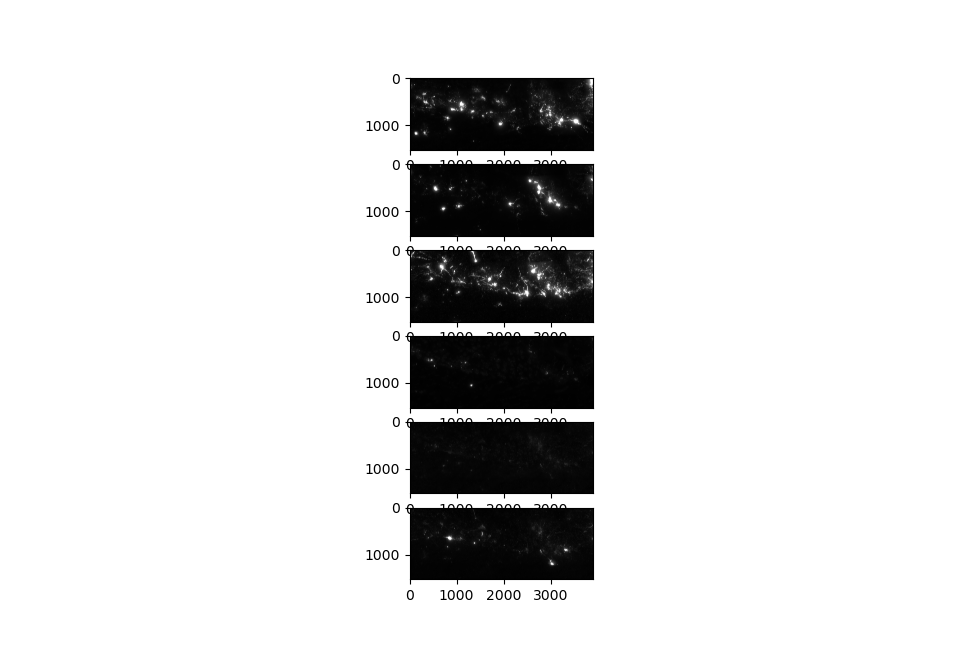

In [166]:
g,axs = plt.subplots(len(imf),1)
for iim in range(len(imf)):
    axs[iim].imshow(imf[iim].T,cmap='gray')

<IPython.core.display.Javascript object>


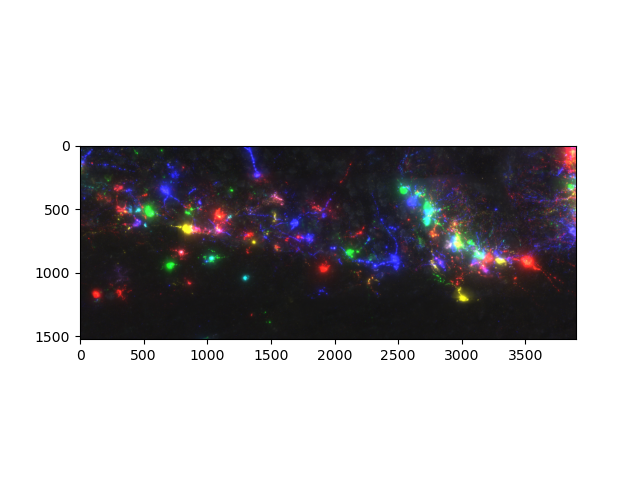

In [162]:
cols = np.array([[1,0,0],[0,1,0],[0,0,1],[0,1,1],[1,0,1],[1,1,0]])[:len(imf)].T
imcol = np.clip(np.dstack(np.dot(cols,np.swapaxes(imf,0,1))),0,1)
plt.figure()
plt.imshow(np.swapaxes(imcol,0,1))

<IPython.core.display.Javascript object>


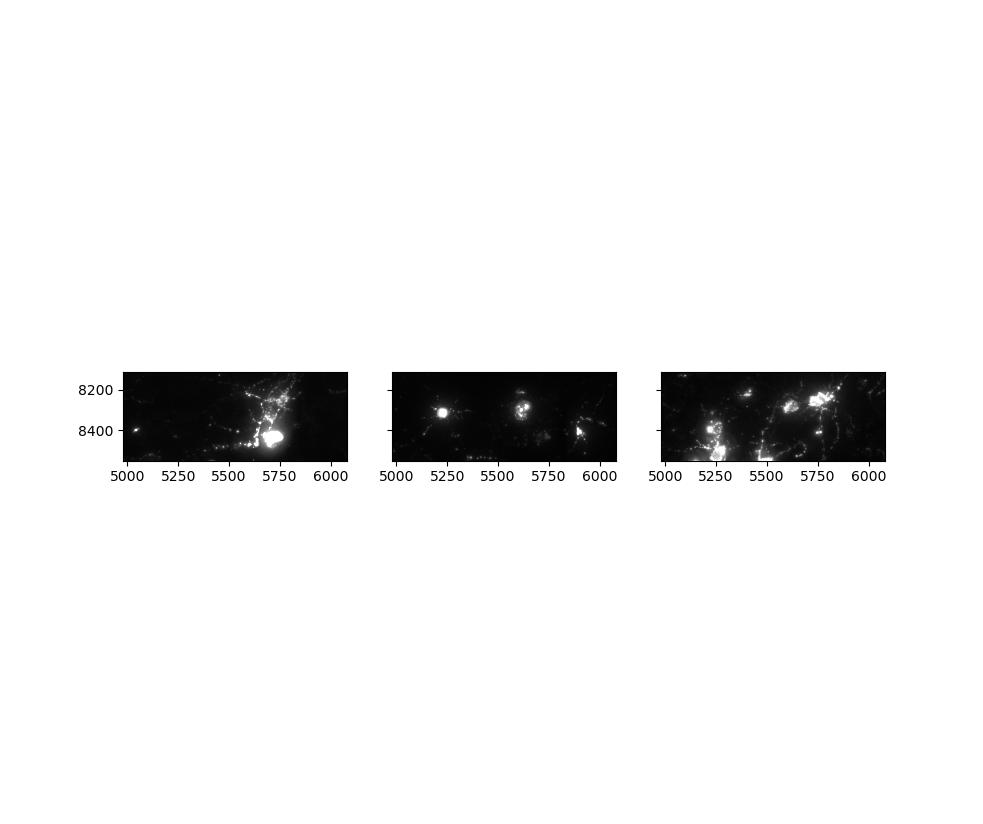

In [115]:
f,(ax0,ax1,ax2) = plt.subplots(1,3,sharex=True,sharey=True)
ax0.imshow(im0[::2,::2],vmax=10000,cmap='gray')
ax1.imshow(im1[::2,::2],vmax=20000,cmap='gray')
ax2.imshow(im2[::2,::2],vmax=60000,cmap='gray')